<a href="https://colab.research.google.com/github/marcinszulczyk/kaggle_titanic_solution/blob/feature%2FMS_Eksploracja_Danych_1/kaggle_titanic_solution_column_cabin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza kolumny Cabin



# Import bibliotek

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import missingno

from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Funkcje pomocnicze

## column Family Size

In [2]:
def colum_family_size_calc(df):
  df['Family_Size'] = 1 + df['SibSp'] + df['Parch']
  print (df['Family_Size'])

## column Cabin

In [15]:
def column_cabin_mask_get(df):
  df["Cabin_Data"] = df["Cabin"].isnull().apply(lambda x: not x)
  print(df["Cabin_Data"])

def column_cabin_deck_get(df):
  df['Deck'] = df['Cabin'].str.slice(0,1)
  print(df['Deck'])

def column_cabin_room_get(df):
  df['Room'] = df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
  print(df['Room'])


## column Name

In [21]:
def column_name_last_name(df):
  df['LastName'] = df['Name'].map(lambda x: x.split(',')[0].lower().strip())
  print (df['LastName'])

def column_name_title(df):
  df['Title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].lower().strip())
  print (df['Title'])

## Analiza danych

In [4]:
def check_column(df, name, histogram = 1, compare = 0):
  size = 80
  print(" Dane kolumny: {0:s}. Typ: {1}".format(name,df[name].dtypes))
  print('-' * size)
  print("| {0:62s} | {1:>12}|".format("Ilość wartości", df[name].count()))
  print("| {0:62s} | {1:>12}|".format("Ilość wartości unikalnych", df[name].nunique()))
  print("| {0:62s} | {1:>12}|".format("Ilość wartości NaN", df[name].isna().sum()))
  print('-' * size)
  print('DESCRIBE:')
  print(df[name].describe())
  print('-' * size)
  print('VALUE COUNTS:')
  print(df[name].value_counts())
  print('-' * size)
  print('HEAD:')
  print(df[name].head())
  print('-' * size)
  if histogram:
    print('HISTOGRAM:')
    fig = px.histogram(df, x =name, width=800)
    fig.show() 
  if compare:
    # print('JOINPLOT:')
    # g = sns.jointplot(data = df, x = name, y = compare, kind = 'kde', cmap = 'rocket')
    # g.plot_joint(plt.scatter, s = 8, marker='+')
    # plt.show()
    f = sns.FacetGrid(df_train, hue=compare, aspect=4)
    f.map(sns.kdeplot,name, shade = True)

    f.set(xlim=(df_train[name].min(), df_train[name].max()))

    f.add_legend()
    plt.show()

# Pobranie danych danych

## Link do Kaggle

https://www.kaggle.com/c/titanic/overview

## Wczytanie danych

In [5]:
df_train = pd.read_csv("https://raw.githubusercontent.com/marcinszulczyk/kaggle_titanic_solution/c48ff96bbfd29c691a78a0e46e3dc2abaeec65c1/data/train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/marcinszulczyk/kaggle_titanic_solution/c48ff96bbfd29c691a78a0e46e3dc2abaeec65c1/data/test.csv")

## Połączenie zbiorów danych

In [6]:
df_all = pd.concat([df_train, df_test])

## Podstawowe informacje o danych

### Opis kolumn


---


**PassengerId**  

ID pasażera


---

**Survived**

Czy pasażer został uratowany

0 - nie został uratowany

1 - został uratowany

---

**Pclass**

Klasa jaką podróżował pasażer

1 - Pierwsza klasa (najwyższy standard)

2 - Druga klasa

3 - Trzecia klasa (najniższy standard)

---

**Name** 

Imię pasażera

Imię, nazwisto, tytuł itp.

---

**Sex**        

Płeć pasażera

male - mężczyzna

female - kobieta

---

**Age**          

Wiek pasażera

Jeżeli było dziecko ale nie miało rodziców to oznaczało, że podróżowało z nianią.

---

**SibSp**

Ilość rodzeństwa na pokładzie - bracia, siostry itp.

---

**Parch**

Ilość rodziców na pokładzie

---

**Ticket**

Numer biletu

---

**Fare**

Koszt biletu

---

**Cabin**

Przedział na statu

---

**Embarked**

Port rozpoczęcia podróży

C - Cherbourg

Q - Queenstown

S - Southampton

---

### Zbiory połączone

In [91]:
df_all.head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Data,Deck,Room,Family_Size,LastName,Title,LastName_New,Test,LastName_ID
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NaN,NaN,2,braund,mr,braund,100,100
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C,85.0,2,cumings,mrs,cumings,182,182
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NaN,NaN,1,heikkinen,miss,heikkinen,334,334
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C,123.0,2,futrelle,mrs,futrelle,272,272
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NaN,NaN,1,allen,mr,allen,15,15
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,False,NaN,NaN,1,moran,mr,moran,543,543
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,True,E,46.0,1,mccarthy,mr,mccarthy,505,505
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,False,NaN,NaN,5,palsson,master,palsson,613,613
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,False,NaN,NaN,3,johnson,mrs,johnson,387,387
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,False,NaN,NaN,2,nasser,mrs,nasser,564,564


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [9]:
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


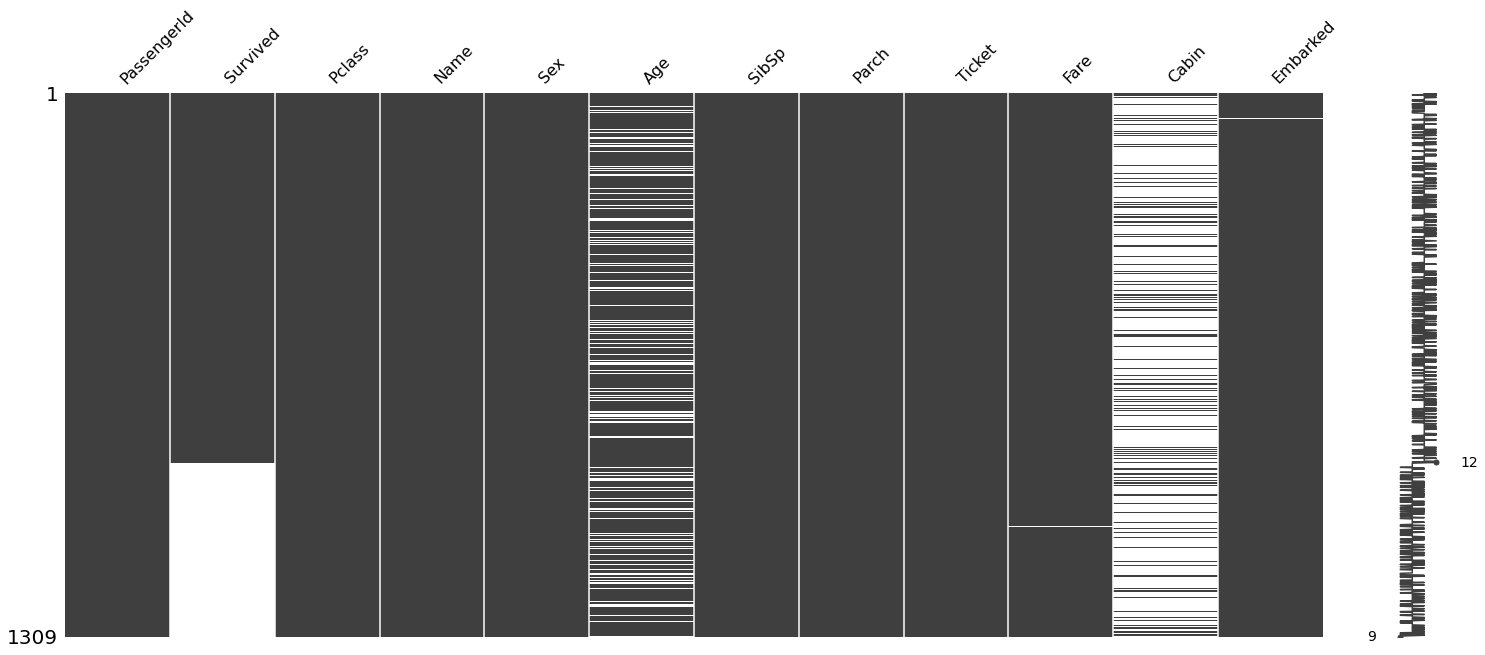

In [10]:
missingno.matrix(df_all)

# Uzupełnienie brakujących danych

Możemy zauważyć, że braki występują w dwóch kolumnach **Age** i **Cabib**.
W pierwszym kroku postaram się uzupełnić te braki poprzez odnalezienie rodzin które prawdopodobnie podrużowały razem.

Aby to zrobić użyje algorytmu k-najbliższych sąsiadów aby określić rodziny z uwzględnieniem następujących kolumn:

*   Wielkość rodziny:

  - suma kolumn **SibSp** i **Parch**
  - suma kolumn musi być różna od 0

*   Nazwisko

  - do wyodrębnienia z kolumny **Name**

*   Ewentualnie port rozpoczecia podróży

  - zakładam, że cała rodzina była zaokrętowana w jednym porcie

*  Ostatnim elementem może być klasa

Po wyznaczeniu tych wartości zajmę się określeniem brakujących pól w kolumnach:

*   **Age**

  - dla małżonków jeżeli będą brakujące dane to przyjmę, że mężczyzna jest o 2 lata starszy (eventualnie wyznaczę medianę różnic wieku)

  - dla dzieci przyjmę dwa lata różnicy między rozdzeństwem, jeżeli jest jedno dziecko to przyjmę wartość średnią wieku dziecka (ewentualnie porównać ze średnią wieku dzieci dla podobnego wieku rodziców)
 
*   **Cabin**

  - zakładam, że cała rodzina była na jednym pokładzie





## Przygotowanie zbioru danych

Do prac użyję połączonego zbioru danych **df_all**

### Analiza kolumny Name

Na podstawie opisu ze strony:

https://www.kaggle.com/c/titanic/discussion/2885

Using the example:

Baclini, Mrs. Solomon (Latifa Qurban)

Mrs. indicates that she is married

Solomon is the name of her husband.   This is a (old-ish) custom where wives can be referred to by their husbands name.  For instance, if Jane Smith was married to John Smith, she could be referred to as Mrs. John Smith.

Latifa is her first name.

Qurban is her "maiden" name.  This is the family/last name that she had before getting married.

Baclini is her (married) family/last name, i.e. the last name of her husband Solomon.

 

For the example

Baclini, Miss. Marie Catherine  (daughter of above)

Miss indicates that she is unmarried, so parsing into first/last names becomes a bit easier. 

In this case Marie is her first name, Catherine is her middle name and Baclini is the family/last name.



### Analiza kolumny Cabin

In [18]:
colum_family_size_calc(df_all)

0      2
1      2
2      1
3      2
4      1
      ..
413    1
414    1
415    1
416    1
417    3
Name: Family_Size, Length: 1309, dtype: int64


In [11]:
# wyświetlenie kolumny Cabin
df_all['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
413     NaN
414    C105
415     NaN
416     NaN
417     NaN
Name: Cabin, Length: 1309, dtype: object

In [12]:
column_cabin_mask_get(df_all)

0      False
1       True
2      False
3       True
4      False
       ...  
413    False
414     True
415    False
416    False
417    False
Name: Cabin_Data, Length: 1309, dtype: bool


#### Wyodrębnienie pokładu

In [13]:
column_cabin_deck_get(df_all)

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
413    NaN
414      C
415    NaN
416    NaN
417    NaN
Name: Deck, Length: 1309, dtype: object


#### Wyodrębnienie kabiny

In [16]:
column_cabin_room_get(df_all)

0        NaN
1       85.0
2        NaN
3      123.0
4        NaN
       ...  
413      NaN
414    105.0
415      NaN
416      NaN
417      NaN
Name: Room, Length: 1309, dtype: float64


In [22]:
column_name_last_name(df_all)

0             braund
1            cumings
2          heikkinen
3           futrelle
4              allen
           ...      
413          spector
414    oliva y ocana
415          saether
416             ware
417            peter
Name: LastName, Length: 1309, dtype: object


In [23]:
column_name_title(df_all)

0          mr
1         mrs
2        miss
3         mrs
4          mr
        ...  
413        mr
414      dona
415        mr
416        mr
417    master
Name: Title, Length: 1309, dtype: object


In [24]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Data,Deck,Room,Family_Size,LastName,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NaN,NaN,2,braund,mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C,85.0,2,cumings,mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NaN,NaN,1,heikkinen,miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C,123.0,2,futrelle,mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NaN,NaN,1,allen,mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,False,NaN,NaN,1,spector,mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,True,C,105.0,1,oliva y ocana,dona
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False,NaN,NaN,1,saether,mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,False,NaN,NaN,1,ware,mr


In [95]:
print(df_all.groupby(['LastName'])['Survived'].value_counts(normalize=True))

LastName   Survived
abbing     0.0         1.0
abbott     0.0         0.5
           1.0         0.5
abelson    0.0         0.5
           1.0         0.5
                      ... 
yousif     0.0         1.0
yousseff   0.0         1.0
yrois      0.0         1.0
zabour     0.0         1.0
zimmerman  0.0         1.0
Name: Survived, Length: 723, dtype: float64


In [99]:
print(df_all.groupby(['LastName'])['Survived'].value_counts(normalize=False).head(20))

LastName         Survived
abbing           0.0         1
abbott           0.0         1
                 1.0         1
abelson          0.0         1
                 1.0         1
adahl            0.0         1
adams            0.0         1
ahlin            0.0         1
aks              1.0         1
albimona         1.0         1
alexander        0.0         1
alhomaki         0.0         1
ali              0.0         2
allen            0.0         1
                 1.0         1
allison          0.0         2
                 1.0         1
allum            0.0         1
andersen-jensen  1.0         1
anderson         1.0         1
Name: Survived, dtype: int64


In [25]:
df_all['LastName_New'] = df_all['LastName']

In [26]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Data,Deck,Room,Family_Size,LastName,Title,LastName_New
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NaN,NaN,2,braund,mr,braund
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C,85.0,2,cumings,mrs,cumings
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NaN,NaN,1,heikkinen,miss,heikkinen
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C,123.0,2,futrelle,mrs,futrelle
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NaN,NaN,1,allen,mr,allen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,False,NaN,NaN,1,spector,mr,spector
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,True,C,105.0,1,oliva y ocana,dona,oliva y ocana
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False,NaN,NaN,1,saether,mr,saether
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,False,NaN,NaN,1,ware,mr,ware


In [41]:
label_encoder = preprocessing.LabelEncoder()

In [42]:
df_all['LastName_ID'] = label_encoder.fit_transform(df_all["LastName"])

In [43]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Data,Deck,Room,Family_Size,LastName,Title,LastName_New,Test,LastName_ID
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NaN,NaN,2,braund,mr,braund,100,100
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C,85.0,2,cumings,mrs,cumings,182,182
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NaN,NaN,1,heikkinen,miss,heikkinen,334,334
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C,123.0,2,futrelle,mrs,futrelle,272,272
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NaN,NaN,1,allen,mr,allen,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,False,NaN,NaN,1,spector,mr,spector,758,758
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,True,C,105.0,1,oliva y ocana,dona,oliva y ocana,598,598
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,False,NaN,NaN,1,saether,mr,saether,704,704
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,False,NaN,NaN,1,ware,mr,ware,834,834


In [73]:
df_cabin = df_all[['LastName_ID', 'Embarked' , 'Deck', 'Family_Size', 'Survived']].copy()
df_cabin

,LastName_ID,Embarked,Deck,Family_Size,Survived
0,100,S,NaN,2,0.0
1,182,C,C,2,1.0
2,334,S,NaN,1,1.0
3,272,S,C,2,1.0
4,15,S,NaN,1,0.0
...,...,...,...,...,...
413,758,S,NaN,1,NaN
414,598,C,C,1,NaN
415,704,S,NaN,1,NaN
416,834,S,NaN,1,NaN


In [74]:
check_column(df_cabin,'Deck')

 Dane kolumny: Deck. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |          295|
| Ilość wartości unikalnych                                      |            8|
| Ilość wartości NaN                                             |         1014|
--------------------------------------------------------------------------------
DESCRIBE:
count     295
unique      8
top         C
freq       94
Name: Deck, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Deck, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Deck, dtype: object
--------------------------------------------------------------------------------
HISTOGRAM:


In [82]:
inputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='N')
df_cabin['Deck_ALL'] = inputer.fit_transform(df_cabin[['Deck']])
print (df_cabin)

     LastName_ID Embarked Deck  Family_Size  Survived Deck_ALL
0            100        S  NaN            2       0.0        N
1            182        C    C            2       1.0        C
2            334        S  NaN            1       1.0        N
3            272        S    C            2       1.0        C
4             15        S  NaN            1       0.0        N
..           ...      ...  ...          ...       ...      ...
413          758        S  NaN            1       NaN        N
414          598        C    C            1       NaN        C
415          704        S  NaN            1       NaN        N
416          834        S  NaN            1       NaN        N
417          639        C  NaN            3       NaN        N

[1309 rows x 6 columns]


In [84]:
check_column(df_cabin,'Deck_ALL')

 Dane kolumny: Deck_ALL. Typ: object
--------------------------------------------------------------------------------
| Ilość wartości                                                 |         1309|
| Ilość wartości unikalnych                                      |            9|
| Ilość wartości NaN                                             |            0|
--------------------------------------------------------------------------------
DESCRIBE:
count     1309
unique       9
top          N
freq      1014
Name: Deck_ALL, dtype: object
--------------------------------------------------------------------------------
VALUE COUNTS:
N    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck_ALL, dtype: int64
--------------------------------------------------------------------------------
HEAD:
0    N
1    C
2    N
3    C
4    N
Name: Deck_ALL, dtype: object
--------------------------------------------------------------------------------
HISTOGRAM:


In [86]:
label_encoder = preprocessing.LabelEncoder()

In [87]:
df_cabin['Deck_ID'] = label_encoder.fit_transform(df_cabin["Deck_ALL"])

In [89]:
px.scatter(df_cabin, x='LastName_ID', y = 'Family_Size', color = 'Deck_ID', width=800)

# Model uczenia

## Pierwszy model

Wykonay w celu sprawdzenia poprawności wygenerowania wyniku i wysyłanego pliku na kaggle.